In [1]:
import os
import time
from pprint import pprint
from tqdm import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


from util import *
import pandas as pd

In [2]:
from docopt import docopt
import os
from pathlib import Path
import importlib
import logging
import yaml

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from util import *
from data_prepare import DataPrep
from models_cnn import VoiceDataset


In [6]:
with open("params_lstm.yml", 'r') as file:
    params = yaml.safe_load(file)

algo = params["algorithm"]
batch_size = int(algo["params"]["batch_size"])
n_epochs = int(algo["params"]["epochs"])
patience = int(algo["params"]["patience"])
learning_rate = float(algo["params"]["learning_rate"])


In [7]:
algo

{'name': {'CNNLSTMNet': {'num_filters_conv1': 64,
   'num_filters_conv2': 128,
   'num_filters_conv3': 256,
   'num_filters_conv4': 512,
   'hidden_size_lstm': 64,
   'dropout_rate': 0.5,
   'num_classes': 200}},
 'params': {'batch_size': 64,
  'cv': False,
  'epochs': 50,
  'learning_rate': 0.001,
  'patience': 100},
 'save_path': 'model.pt'}

In [8]:
# Get data
from sklearn.model_selection import train_test_split
data = DataPrep("data/preprocessed/train_len5_mfcc", "data/preprocessed/df_index_train.pkl")
data.load()
data.get_data_info()
X, y, labels = data.get_data(labels=True)

# Prepare data for training
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create VoiceDataset object
train_dataset = VoiceDataset(X_train, y_train)
val_dataset = VoiceDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



100it [00:01, 58.67it/s]


X shape: (49664, 17, 216)
y shape: (49664,)
labels shape: (49664,)
Number of unique speakers: 200
Number of unique classes: 200
Unique classes: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


In [9]:
device = get_cuda_device()


NameError: name 'get_model' is not defined

In [10]:
def get_model(algo):
    NAME = list(algo["name"].keys())[0]
    module = importlib.import_module("models_cnn")

    if "num_classes" in algo["name"][NAME]:
        model = getattr(module, NAME)(**algo["name"][NAME])

    return model

In [11]:
get_model(algo)

CNNLSTMNet(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu4): ReLU()
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(95744, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=38

In [351]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [363]:
from data_prepare import *

FILE_DIR = Path(DATA_ADDRESS) / "VOiCES_devkit"
TRAIN_DIR = Path(DATA_ADDRESS) / "preprocessed/train"
INDEX_DIR = Path(DATA_ADDRESS) / "preprocessed"

data = DataPrep(FILE_DIR, TRAIN_DIR, INDEX_DIR, 15)
data.load()
data.get_data_info()

X, y, labels = data.get_data(labels=True)

100it [00:01, 66.52it/s]


X shape: (3840, 17, 216)
y shape: (3840,)
labels shape: (3840,)
Number of unique speakers: 15
Number of unique classes: 15
Unique classes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [408]:
def get_cuda_device():
    import torch
    # Check if GPUs are available
    if torch.cuda.is_available():
        # Set the default device to GPU
        torch.cuda.set_device(0)  # Specify the GPU device index if using multiple GPUs
        device = torch.device('cuda')
    else:
        # Set the default device to CPU
        # torch.set_default_tensor_type('torch.FloatTensor')
        device = torch.device('cpu')

    return device


In [1]:
from data_prepare import *

from sklearn.model_selection import train_test_split
from util import *

FILE_DIR = Path(DATA_ADDRESS) / "VOiCES_devkit"
TRAIN_DIR = Path(DATA_ADDRESS) / "preprocessed/train"
INDEX_DIR = Path(DATA_ADDRESS) / "preprocessed"

data = DataPrep(FILE_DIR, TRAIN_DIR, INDEX_DIR, 15)
data.load()
data.get_data_info()

X, y, labels = data.get_data(labels=True)

# Create
device = get_cuda_device()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2024)

# Create VoiceDataset object
train_dataset = VoiceDataset(X, y)
val_dataset = VoiceDataset(X_val, y_val)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


100it [00:00, 137.71it/s]


X shape: (3840, 17, 216)
y shape: (3840,)
labels shape: (3840,)
Number of unique speakers: 15
Number of unique classes: 15
Unique classes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [2]:
model = AudioCNN(num_classes=15)

In [4]:
model2 = BaseCNN(num_classes=15)

In [7]:
import yaml
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file)

params

{'algorithm': {'name': {'BaseCNN': {'num_classes': 20}},
  'params': {'batch_size': 32,
   'cv': False,
   'epochs': 5,
   'learning_rate': 0.001,
   'patients': 15},
  'save_path': 'model.pt'}}

In [2]:
from train_cnn import *

In [3]:
params["algorithm"]

{'name': {'BaseCNN': {'num_classes': 15}},
 'params': {'batch_size': 32,
  'cv': False,
  'epochs': 5,
  'learning_rate': 0.001,
  'patients': 15},
 'save_path': 'model.pt'}

In [8]:
tmp = get_model(params["algorithm"])

In [13]:
params["algorithm"]["params"]

{'batch_size': 32,
 'cv': False,
 'epochs': 5,
 'learning_rate': 0.001,
 'patients': 15}

In [400]:
from sklearn.model_selection import GroupKFold, KFold

# Define the number of folds and batch size
k_folds = 5
batch_size = 32

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the k-fold cross validation
# may consider group-k-fold for the distractor type in the next interation
kf = KFold(n_splits=k_folds)

In [401]:
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}")
    print("-------")
    print(f"Train indices length: {len(train_idx)}")
    print(f"Test indices length: {len(test_idx)}")

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=X,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    test_loader = DataLoader(
        dataset=X,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )

    # X_train = X[train_idx]
    # y_train = y[train_idx]
    # labels_train = labels[train_idx]
    #
    # X_test = X[test_idx]
    # y_test = y[test_idx]
    # labels_test = labels[test_idx]

    # Initialize the model and optimizer
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)


    # Train the model on the current fold
    for epoch in range(1, 11):
        train(model, device, train_loader, optimizer, epoch)

    break

Fold 1
-------
Train indices length: 3072
Test indices length: 768


In [402]:
X_train.shape

(3072, 17, 216)

In [403]:
set(y_train)

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0}

In [404]:
set(y_test)

{0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0}

In [405]:
set(labels_train)

{'0242',
 '0248',
 '1926',
 '2573',
 '3521',
 '3835',
 '4064',
 '4160',
 '5189',
 '5583',
 '5968',
 '6395',
 '7498',
 '8266',
 '8575'}

In [406]:
set(labels_test)

{'0242',
 '0248',
 '1926',
 '2573',
 '3521',
 '3835',
 '4064',
 '4160',
 '5189',
 '5583',
 '5968',
 '6395',
 '7498',
 '8266'}

In [345]:
torch.tensor(X, dtype=torch.float)
torch.tensor(y, dtype=torch.long)
len(y)

3840

In [348]:
voice = VoiceDataset(X, y)
x1, y1= voice.__getitem__(0)

In [350]:
y1

tensor(10)

In [330]:
import numpy as np
import os
from util import *
import pandas as pd
from pathlib import Path

FILE_DIR = Path(DATA_ADDRESS) / "VOiCES_devkit"
TRAIN_DIR = Path(DATA_ADDRESS) / "preprocessed/train"
INDEX_DIR = Path(DATA_ADDRESS) / "preprocessed"

def prepare_index_data(path, num_classes=None):
    """
    Prepare the index data
    :param path
    :param num_classes (optional): specify an integer to add a column to subset the data to randomly selected N
    speakers (speakerN (0/1), speakerN_class (0-N-1)
    :return: 2 dataframes (df_index_reference, df_files_to_load)
    """
    df_index = pd.read_pickle(path)

    # create a column in train for count of speakers repeats
    df_index = df_index.merge(df_index.groupby('speaker').size().reset_index
                                          (name='n_samples_per_speaker'), on='speaker', how='left')

    # select unique speaker-pkl_filename
    df_index['pkl_filename'] = df_index['pkl_file_dir'].apply(lambda x: Path(x).name)
    df_index_unique = df_index[["file_index", 'speaker', 'pkl_filename', 'n_samples_per_speaker']].drop_duplicates()

    # make sure the pkl filenames are loaded in the same order as in df_index_train
    df_files_to_load = df_index_unique[["pkl_filename"]].drop_duplicates()
    df_files_to_load = df_files_to_load.reset_index().sort_values(by='index').reset_index(drop=True)

    df_index_reference = df_index_unique.merge(df_files_to_load, on='pkl_filename',
                                                           how='left').sort_values \
        (by=['index', 'file_index']) \
        .reset_index(drop=True)

    df_index_reference["speaker_full_array_index"] = np.array(range(len(df_index_reference)))
    df_index_reference["pkl_filename_index"] = df_index_reference["index"]
    df_index_reference = df_index_reference[['file_index', 'pkl_filename', 'pkl_filename_index',
                                             'n_samples_per_speaker', 'speaker',
                                             'speaker_full_array_index']]

    # prepare labels
    speaker_map = {speaker: i for i, speaker in enumerate(df_index_reference["speaker"].unique())}
    df_index_reference['speaker_class'] = df_index_reference['speaker'].map(speaker_map)

    if num_classes:
        speakers = df_index_reference[df_index_reference['n_samples_per_speaker'] == 256]['speaker'].sample(
            num_classes, random_state=2024).values

        df_index_reference[f"speaker{num_classes}"] = df_index_reference['speaker'].apply(
            lambda x: 1 if x in speakers else 0)

        speaker_map = {speaker: i for i, speaker in enumerate(speakers)}
        df_index_reference[f"speaker{num_classes}_class"] = df_index_reference['speaker'].map(speaker_map)

    return df_index_reference, df_files_to_load

def load_data(df_index_reference, df_files_to_load, input_dir, num_classes=None, verbose=False):
    """
    Load the data
    :param df_index_reference: output of prepare_index_data
    :param df_files_to_load: output of prepare_index_data
    :param input_dir: directory to pkl files location
    :param num_classes: specify an integer to subset the data to randomly selected N speakers in prepare_index_data (
    must be the same as num_classes in prepare_index_data)
    :param verbose: print the filename being loaded
    :return: X, y, labels (speaker IDs)
    """
    if not isinstance(input_dir, Path):
        input_dir = Path(input_dir)
    X_ls = []
    filenames = []
    for index, row in tqdm(df_files_to_load.iterrows()):
        filename = row['pkl_filename']
        if verbose:
            print("Loading: ", filename)
        x = load_pickle(input_dir / filename)
        X_ls.append(x)
        filenames.append(filename)
    X = np.concatenate(X_ls, axis=0)

    labels = df_index_reference["speaker"].values
    y = df_index_reference["speaker_class"].values

    if num_classes:
        # subset to speaker15=1 and make sure it's sorted by how files will be loaded
        df_index_reference_sub =df_index_reference[df_index_reference[f"speaker{num_classes}"] == 1].sort_values\
            (by=["pkl_filename_index","pkl_filename"]).copy()


        X = X[df_index_reference_sub["speaker_full_array_index"].values]

        labels = df_index_reference_sub["speaker"].values
        y = df_index_reference_sub[f"speaker{num_classes}_class"].values

    return X, y, labels


In [331]:
df_index_reference, df_files_to_load = prepare_index_data(INDEX_DIR / "df_index_train.pkl", 15)
X, y, labels = load_data(df_index_reference, df_files_to_load, TRAIN_DIR, 15)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"labels shape: {labels.shape}")


100it [00:00, 190.91it/s]


X shape: (3840, 17, 216)
y shape: (3840,)
labels shape: (3840,)


In [3]:
files = os.listdir(TRAIN_DIR)
len(files)

100

In [227]:
df_index_train = pd.read_pickle(DATA_ADDRESS+"preprocessed/df_index_train.pkl")
df_index_test = pd.read_pickle(DATA_ADDRESS+"preprocessed/df_index_test.pkl")

In [228]:
# create a column in train for count of speakers repeats
df_index_train = df_index_train.merge(df_index_train.groupby('speaker').size().reset_index
                                    (name='n_samples_per_speaker'), on='speaker', how='left')

In [229]:
df_index_train

,file_index,old_index,origin_folder,speaker,distractor,room,category,filename,pkl_file_dir,n_samples_per_speaker
0,0,30,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256
1,1,31,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256
2,2,32,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256
3,3,33,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256
4,4,34,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256
...,...,...,...,...,...,...,...,...,...,...
49659,159,74443,distant-16k/speech/train/rm3/tele/sp2764,2764,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp2764/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256
49660,160,74444,distant-16k/speech/train/rm3/tele/sp2764,2764,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp2764/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256
49661,161,74445,distant-16k/speech/train/rm3/tele/sp2764,2764,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp2764/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256
49662,162,74446,distant-16k/speech/train/rm3/tele/sp2764,2764,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp2764/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256


In [300]:
df_index_train

,file_index,old_index,origin_folder,speaker,distractor,room,category,filename,pkl_file_dir,n_samples_per_speaker,pkl_filename
0,0,30,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
1,1,31,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
2,2,32,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
3,3,33,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
4,4,34,distant-16k/speech/train/rm4/musi/sp1121,1121,musi,rm4,train,5seconds-16k/speech/train/rm4/musi/sp1121/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
...,...,...,...,...,...,...,...,...,...,...,...
49659,159,74443,distant-16k/speech/train/rm3/tele/sp2764,2764,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp2764/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl
49660,160,74444,distant-16k/speech/train/rm3/tele/sp2764,2764,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp2764/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl
49661,161,74445,distant-16k/speech/train/rm3/tele/sp2764,2764,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp2764/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl
49662,162,74446,distant-16k/speech/train/rm3/tele/sp2764,2764,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp2764/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl


In [258]:
# select unique speaker-pkl_filename
df_index_train['pkl_filename'] = df_index_train['pkl_file_dir'].apply(lambda x: Path(x).name)
df_index_train_unique = df_index_train[["file_index", 'speaker', 'pkl_filename', "n_samples_per_speaker"]].drop_duplicates()
df_index_train_unique

,file_index,speaker,pkl_filename,n_samples_per_speaker
0,0,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256
1,1,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256
2,2,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256
3,3,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256
4,4,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256
...,...,...,...,...
49659,159,2764,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256
49660,160,2764,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256
49661,161,2764,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256
49662,162,2764,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256


In [261]:
df_index_train_unique["n_samples_per_speaker"].value_counts()

n_samples_per_speaker
256    41728
224     5824
192     1344
320      320
160      320
128      128
Name: count, dtype: int64

In [262]:
# make sure the pkl filenames are loaded in the same order as in df_index_train
df_files_to_load = df_index_train_unique[["pkl_filename"]].drop_duplicates()
df_files_to_load = df_files_to_load.reset_index().sort_values(by='index').reset_index(drop=True)

In [263]:
df_files_to_load

,index,pkl_filename
0,0,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
1,500,mfcc_len5_fft2048_mels128_mfcc17_500-999.pkl
2,1000,mfcc_len5_fft2048_mels128_mfcc17_1000-1499.pkl
3,1500,mfcc_len5_fft2048_mels128_mfcc17_1500-1999.pkl
4,2000,mfcc_len5_fft2048_mels128_mfcc17_2000-2499.pkl
...,...,...
95,47500,mfcc_len5_fft2048_mels128_mfcc17_47500-47999.pkl
96,48000,mfcc_len5_fft2048_mels128_mfcc17_48000-48499.pkl
97,48500,mfcc_len5_fft2048_mels128_mfcc17_48500-48999.pkl
98,49000,mfcc_len5_fft2048_mels128_mfcc17_49000-49499.pkl


In [240]:
def load_data(df, input_dir, verbose=False):
    if not isinstance(input_dir, Path):
        input_dir = Path(input_dir)
    X_ls = []
    filenames = []
    for index, row in tqdm(df.iterrows()):
        filename = row['pkl_filename']
        if verbose:
            print("Loading: ", filename)
        x = load_pickle(os.path.join(input_dir, filename))
        X_ls.append(x)
        filenames.append(filename)
    X = np.concatenate(X_ls, axis=0)
    return X, filenames

X, filenames = load_data(df_files_to_load, TRAIN_DIR)

100it [00:00, 147.45it/s]


In [264]:
df_index_train_reference = df_index_train_unique.merge(df_files_to_load, on='pkl_filename', how='left').sort_values\
    (by=['index', 'file_index'])\
    .reset_index(drop=True)

df_index_train_reference

,file_index,speaker,pkl_filename,n_samples_per_speaker,index
0,0,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,0
1,1,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,0
2,2,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,0
3,3,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,0
4,4,1121,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,0
...,...,...,...,...,...
49659,159,2764,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,49500
49660,160,2764,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,49500
49661,161,2764,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,49500
49662,162,2764,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,49500


In [265]:
df_index_train_reference["speaker_index"] = np.array(range(len(df_index_train_reference)))
df_index_train_reference = df_index_train_reference[['file_index', 'pkl_filename', 'n_samples_per_speaker', 'speaker', 'speaker_index']]

In [266]:
df_index_train_reference

,file_index,pkl_filename,n_samples_per_speaker,speaker,speaker_index
0,0,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,0
1,1,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,1
2,2,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,2
3,3,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,3
4,4,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,4
...,...,...,...,...,...
49659,159,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49659
49660,160,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49660
49661,161,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49661
49662,162,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49662


In [280]:
label = df_index_train_reference['speaker'].values

# select 15 random speakers whose count of samples 256 and create a column (speaker15 for 0/1)
speakers = df_index_train_reference[df_index_train_reference['n_samples_per_speaker']==256]['speaker'].sample(15,random_state=2024).values

df_index_train_reference['speaker15'] = df_index_train_reference['speaker'].apply(lambda x: 1 if x in speakers else 0)

df_index_train_reference

,file_index,pkl_filename,n_samples_per_speaker,speaker,speaker_index,speaker15,speaker15_class
0,0,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,0,0,NaN
1,1,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,1,0,NaN
2,2,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,2,0,NaN
3,3,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,3,0,NaN
4,4,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,4,0,NaN
...,...,...,...,...,...,...,...
49659,159,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49659,0,NaN
49660,160,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49660,0,NaN
49661,161,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49661,0,NaN
49662,162,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49662,0,NaN


In [285]:
# map values 0-len(speakers) for classes
speaker_map = {speaker: i for i, speaker in enumerate(speakers)}
# add as a column to df_index_train_reference
df_index_train_reference['speaker15_class'] = df_index_train_reference['speaker'].map(speaker_map)

In [286]:
speaker_map = {speaker: i for i, speaker in enumerate(df_index_train_reference["speaker"].unique())}

df_index_train_reference['speaker_class'] = df_index_train_reference['speaker'].map(speaker_map)

df_index_train_reference

,file_index,pkl_filename,n_samples_per_speaker,speaker,speaker_index,speaker15,speaker15_class,speaker_class
0,0,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,0,0,NaN,0
1,1,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,1,0,NaN,0
2,2,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,2,0,NaN,0
3,3,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,3,0,NaN,0
4,4,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,4,0,NaN,0
...,...,...,...,...,...,...,...,...
49659,159,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49659,0,NaN,28
49660,160,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49660,0,NaN,28
49661,161,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49661,0,NaN,28
49662,162,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49662,0,NaN,28


In [275]:
df_index_train_reference

,file_index,pkl_filename,n_samples_per_speaker,speaker,speaker_index,speaker15,speaker15_class
0,0,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,0,0,NaN
1,1,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,1,0,NaN
2,2,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,2,0,NaN
3,3,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,3,0,NaN
4,4,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,256,1121,4,0,NaN
...,...,...,...,...,...,...,...
49659,159,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49659,0,NaN
49660,160,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49660,0,NaN
49661,161,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49661,0,NaN
49662,162,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,256,2764,49662,0,NaN


In [252]:
for y, label in zip(y, label):
    print(y, label) # something is off with labels

0 1121
1 1121
2 1121
3 1121
4 1121
5 1121
6 1121
7 1121
8 1121
9 1121
10 1121
11 1121
12 1121
13 1121
14 1121
15 1121
16 6848
17 6848
18 6848
19 6848
20 6848
21 6848
22 6848
23 6848
24 6848
25 6848
26 6848
27 6848
28 6848
29 6848
30 6848
31 6848
32 7095
33 7095
34 7095
35 7095
36 7095
37 7095
38 7095
39 7095
40 7095
41 7095
42 7095
43 7095
44 7095
45 7095
46 5789
47 5789
48 5789
49 5789
50 5789
51 5789
52 5789
53 5789
54 5789
55 5789
56 5789
57 5789
58 5789
59 5789
60 5789
61 5789
62 1050
63 1050
64 1050
65 1050
66 1050
67 1050
68 1050
69 1050
70 1050
71 1050
72 1050
73 1050
74 1050
75 1050
76 6788
77 6788
78 6788
79 6788
80 6788
81 6788
82 6788
83 6788
84 6788
85 6788
86 6788
87 6788
88 6788
89 6788
90 6788
91 6788
92 0032
93 0032
94 0032
95 0032
96 0032
97 0032
98 0032
99 0032
100 0032
101 0032
102 0032
103 0032
104 0032
105 0032
106 0032
107 0032
108 4331
109 4331
110 4331
111 4331
112 4331
113 4331
114 4331
115 4331
116 4331
117 4331
118 4331
119 4331
120 4331
121 4331
122 4331
123

In [ ]:
# load everything to X and then the same y for speaker IDS
X = load_train(TRAIN_DIR, files)

In [25]:
# select 15 random speakers whose count of samples is at least 256
import seedbank
seedbank.initialize(2024)

2024-02-12 01:12:54.109351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


SeedSequence(
    entropy=2024,
)

In [54]:
speakers = df_index_train[df_index_train['n_samples_per_speaker']==256]['speaker'].sample(15, random_state=2024)

speakers = speakers.reset_index(drop=True).reset_index()
speakers = speakers.rename(columns={'index':'label'})


In [56]:
speakers

,label,speaker
0,0,8266
1,1,6395
2,2,1926
3,3,5968
4,4,2573
5,5,8575
6,6,5583
7,7,5189
8,8,0242
9,9,4064


In [60]:
df_index_train_sub = df_index_train[df_index_train['speaker'].isin(speakers['speaker'])]
df_index_train_sub = df_index_train_sub.merge(speakers, on='speaker', how='left')

In [92]:
df_index_train.loc[500, "pkl_file_dir"]

'preprocessed/train/mfcc_len5_fft2048_mels128_mfcc17_500-999.pkl'

In [71]:
len(set(df_index_train_sub['pkl_file_dir'].values))

93

In [148]:
from pathlib import Path
files = os.listdir(TRAIN_DIR)
len(files)

100

In [152]:
df_index_train['pkl_filename'] = df_index_train['pkl_file_dir'].apply(lambda x: Path(x).name)
len(set(df_index_train['pkl_filename'].values))
df_index_train = df_index_train.sort_values(by=['pkl_filename', 'file_index'])

In [167]:
df_index_train["pkl_file_dir"].loc[1, "file_index"]



IndexingError: Too many indexers

In [151]:
# load everything to X and then the same y for speaker IDS

,pkl_filename,min,max
0,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,499
1,mfcc_len5_fft2048_mels128_mfcc17_1000-1499.pkl,0,499
2,mfcc_len5_fft2048_mels128_mfcc17_10000-10499.pkl,0,499
3,mfcc_len5_fft2048_mels128_mfcc17_10500-10999.pkl,0,499
4,mfcc_len5_fft2048_mels128_mfcc17_11000-11499.pkl,0,499
...,...,...,...
95,mfcc_len5_fft2048_mels128_mfcc17_7500-7999.pkl,0,499
96,mfcc_len5_fft2048_mels128_mfcc17_8000-8499.pkl,0,499
97,mfcc_len5_fft2048_mels128_mfcc17_8500-8999.pkl,0,499
98,mfcc_len5_fft2048_mels128_mfcc17_9000-9499.pkl,0,499


In [ ]:
# Load everything to X and then the same y for speaker IDS
X = load_train(TRAIN_DIR, files)


In [94]:
df_index_train_sub['pkl_filename'] = df_index_train_sub['pkl_file_dir'].apply(lambda x: Path(x).name)

In [104]:
# sort by pkl_filename and file_index
df_index_train_sub = df_index_train_sub.sort_values(by=['pkl_filename', 'file_index'])
df_index_train_sub

,file_index,old_index,origin_folder,speaker,distractor,room,category,filename,pkl_file_dir,n_samples_per_speaker,label,pkl_filename
0,446,650,distant-16k/speech/train/rm4/babb/sp3521,3521,babb,rm4,train,5seconds-16k/speech/train/rm4/babb/sp3521/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,10,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
1,447,651,distant-16k/speech/train/rm4/babb/sp3521,3521,babb,rm4,train,5seconds-16k/speech/train/rm4/babb/sp3521/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,10,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
2,448,652,distant-16k/speech/train/rm4/babb/sp3521,3521,babb,rm4,train,5seconds-16k/speech/train/rm4/babb/sp3521/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,10,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
3,449,653,distant-16k/speech/train/rm4/babb/sp3521,3521,babb,rm4,train,5seconds-16k/speech/train/rm4/babb/sp3521/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,10,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
4,450,654,distant-16k/speech/train/rm4/babb/sp3521,3521,babb,rm4,train,5seconds-16k/speech/train/rm4/babb/sp3521/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,10,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl
...,...,...,...,...,...,...,...,...,...,...,...,...
651,345,14963,distant-16k/speech/train/rm3/tele/sp6395,6395,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp6395/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,1,mfcc_len5_fft2048_mels128_mfcc17_9500-9999.pkl
652,346,14964,distant-16k/speech/train/rm3/tele/sp6395,6395,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp6395/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,1,mfcc_len5_fft2048_mels128_mfcc17_9500-9999.pkl
653,347,14965,distant-16k/speech/train/rm3/tele/sp6395,6395,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp6395/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,1,mfcc_len5_fft2048_mels128_mfcc17_9500-9999.pkl
654,348,14966,distant-16k/speech/train/rm3/tele/sp6395,6395,tele,rm3,train,5seconds-16k/speech/train/rm3/tele/sp6395/Lab4...,preprocessed/train/mfcc_len5_fft2048_mels128_m...,256,1,mfcc_len5_fft2048_mels128_mfcc17_9500-9999.pkl


In [142]:
df_index_train_sub.groupby("pkl_filename").agg({'file_index': "count"})

,file_index
pkl_filename,
mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,16
mfcc_len5_fft2048_mels128_mfcc17_1000-1499.pkl,16
mfcc_len5_fft2048_mels128_mfcc17_10000-10499.pkl,48
mfcc_len5_fft2048_mels128_mfcc17_10500-10999.pkl,64
mfcc_len5_fft2048_mels128_mfcc17_11000-11499.pkl,32
...,...
mfcc_len5_fft2048_mels128_mfcc17_7000-7499.pkl,48
mfcc_len5_fft2048_mels128_mfcc17_7500-7999.pkl,48
mfcc_len5_fft2048_mels128_mfcc17_8000-8499.pkl,6


In [117]:
# group by pkl_filename get min and mac values of file_index
tmp = df_index_train_sub.groupby('pkl_filename').agg({'file_index': ['min', 'max']})
tmp.columns = ['min', 'max']
tmp = tmp.reset_index()
tmp

,pkl_filename,min,max
0,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,446,461
1,mfcc_len5_fft2048_mels128_mfcc17_1000-1499.pkl,290,305
2,mfcc_len5_fft2048_mels128_mfcc17_10000-10499.pkl,148,487
3,mfcc_len5_fft2048_mels128_mfcc17_10500-10999.pkl,20,365
4,mfcc_len5_fft2048_mels128_mfcc17_11000-11499.pkl,200,457
...,...,...,...
88,mfcc_len5_fft2048_mels128_mfcc17_7000-7499.pkl,42,347
89,mfcc_len5_fft2048_mels128_mfcc17_7500-7999.pkl,138,265
90,mfcc_len5_fft2048_mels128_mfcc17_8000-8499.pkl,494,499
91,mfcc_len5_fft2048_mels128_mfcc17_8500-8999.pkl,0,441


In [143]:
X_ls = []
for index, row in tmp.iterrows():
    filename = row['pkl_filename']
    min_index = row['min']
    max_index = row['max']
    x = load_pickle(os.path.join(TRAIN_DIR, filename))
    x = x[min_index:max_index+1]
    X_ls.append(x)

X = np.concatenate(X_ls, axis=0)


In [144]:
X.shape

(19150, 17, 216)

In [138]:
X[446:461+1].shape

(16, 17, 216)

In [98]:
X = load_train(TRAIN_DIR, os.listdir(TRAIN_DIR))
print("Original shape: ", X.shape)

# subset by file_index in df_index_train_sub
X = X[df_index_train_sub['file_index'].values]
print("Subset shape: ", X.shape)

100%|██████████| 100/100 [00:00<00:00, 234.61it/s]


Original shape:  (49664, 17, 216)
Subset shape:  (3840, 17, 216)


In [101]:
df_index_train_sub['file_index'].values

array([  0,   0,   0, ..., 499, 499, 499])

In [4]:

tmp = load_pickle(TRAIN_DIR+files[5])
tmp.shape


(500, 17, 216)

In [301]:
from util import *
import pandas as pd
from pathlib import Path

FILE_DIR = Path(DATA_ADDRESS) / "VOiCES_devkit"
TRAIN_DIR = Path(DATA_ADDRESS) / "preprocessed/train"
INDEX_DIR = Path(DATA_ADDRESS) / "preprocessed"

def prepare_index_data(path, num_classes=None):
    """
    Prepare the index data
    :param path
    :param num_classes (optional): specify an integer to add a column to subset the data to randomly selected N
    speakers (speakerN (0/1), speakerN_class (0-N-1)
    :return: 2 dataframes (df_index_reference, df_files_to_load)
    """
    df_index = pd.read_pickle(path)

    # create a column in train for count of speakers repeats
    df_index = df_index.merge(df_index.groupby('speaker').size().reset_index
                                          (name='n_samples_per_speaker'), on='speaker', how='left')

    # select unique speaker-pkl_filename
    df_index['pkl_filename'] = df_index['pkl_file_dir'].apply(lambda x: Path(x).name)
    df_index_unique = df_index[["file_index", 'speaker', 'pkl_filename', 'n_samples_per_speaker']].drop_duplicates()

    # make sure the pkl filenames are loaded in the same order as in df_index_train
    df_files_to_load = df_index_unique[["pkl_filename"]].drop_duplicates()
    df_files_to_load = df_files_to_load.reset_index().sort_values(by='index').reset_index(drop=True)

    df_index_reference = df_index_unique.merge(df_files_to_load, on='pkl_filename',
                                                           how='left').sort_values \
        (by=['index', 'file_index']) \
        .reset_index(drop=True)

    df_index_reference["speaker_full_array_index"] = np.array(range(len(df_index_reference)))
    df_index_reference["pkl_filename_index"] = df_index_reference["index"]
    df_index_reference = df_index_reference[['file_index', 'pkl_filename', 'pkl_filename_index',
                                             'n_samples_per_speaker', 'speaker',
                                             'speaker_full_array_index']]


    # prepare labels
    speaker_map = {speaker: i for i, speaker in enumerate(df_index_reference["speaker"].unique())}
    df_index_reference['speaker_class'] = df_index_reference['speaker'].map(speaker_map)

    if num_classes:
        speakers = df_index_reference[df_index_reference['n_samples_per_speaker'] == 256]['speaker'].sample(
            num_classes, random_state=2024).values

        df_index_reference[f"speaker{num_classes}"] = df_index_reference['speaker'].apply(
            lambda x: 1 if x in speakers else 0)

        speaker_map = {speaker: i for i, speaker in enumerate(speakers)}
        df_index_reference[f"speaker{num_classes}_class"] = df_index_reference['speaker'].map(speaker_map)

    return df_index_reference, df_files_to_load


In [304]:
df_index_reference, df_files_to_load = prepare_index_data(INDEX_DIR / "df_index_train.pkl", 15)
df_index_reference

,file_index,pkl_filename,pkl_filename_index,n_samples_per_speaker,speaker,speaker_full_array_index,speaker_class,speaker15,speaker15_class
0,0,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,0,0,0,NaN
1,1,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,1,0,0,NaN
2,2,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,2,0,0,NaN
3,3,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,3,0,0,NaN
4,4,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,4,0,0,NaN
...,...,...,...,...,...,...,...,...,...
49659,159,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,49500,256,2764,49659,28,0,NaN
49660,160,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,49500,256,2764,49660,28,0,NaN
49661,161,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,49500,256,2764,49661,28,0,NaN
49662,162,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,49500,256,2764,49662,28,0,NaN


In [321]:
df_index_reference

,file_index,pkl_filename,pkl_filename_index,n_samples_per_speaker,speaker,speaker_full_array_index,speaker_class,speaker15,speaker15_class
0,0,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,0,0,0,NaN
1,1,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,1,0,0,NaN
2,2,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,2,0,0,NaN
3,3,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,3,0,0,NaN
4,4,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,1121,4,0,0,NaN
...,...,...,...,...,...,...,...,...,...
49659,159,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,49500,256,2764,49659,28,0,NaN
49660,160,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,49500,256,2764,49660,28,0,NaN
49661,161,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,49500,256,2764,49661,28,0,NaN
49662,162,mfcc_len5_fft2048_mels128_mfcc17_49500-49663.pkl,49500,256,2764,49662,28,0,NaN


In [309]:
# subset to speaker15=1 and make sure its sorted by how files will be loaded
df_index_reference_sub = df_index_reference[df_index_reference['speaker15']==1].sort_values(by=["pkl_filename_index",
                                                                                   "pkl_filename"])

In [313]:
df_index_reference_sub

,file_index,pkl_filename,pkl_filename_index,n_samples_per_speaker,speaker,speaker_full_array_index,speaker_class,speaker15,speaker15_class
446,446,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,446,27,1,10.0
447,447,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,447,27,1,10.0
448,448,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,448,27,1,10.0
449,449,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,449,27,1,10.0
450,450,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,450,27,1,10.0
...,...,...,...,...,...,...,...,...,...
49231,231,mfcc_len5_fft2048_mels128_mfcc17_49000-49499.pkl,49000,256,5968,49231,78,1,3.0
49232,232,mfcc_len5_fft2048_mels128_mfcc17_49000-49499.pkl,49000,256,5968,49232,78,1,3.0
49233,233,mfcc_len5_fft2048_mels128_mfcc17_49000-49499.pkl,49000,256,5968,49233,78,1,3.0
49234,234,mfcc_len5_fft2048_mels128_mfcc17_49000-49499.pkl,49000,256,5968,49234,78,1,3.0


In [318]:
# get speaker labels
labels = df_index_reference_sub["speaker"].values
y = df_index_reference_sub[f"speaker{num_classes}_class"].values
# get speaker classes
# df_index_reference_sub["speaker15_class"].unique()

(3840,)

In [320]:
# slice X by speaker_full_array_index
X_sub = X[df_index_reference_sub["speaker_full_array_index"].values]
X_sub.shape

(3840, 17, 216)

In [5]:
import librosa
signal, sr = librosa.load("/Users/m243289/Documents/Drexel/Drexel2023/DSCI591/DSCI_Capstone/data/VOiCES_devkit/distant"
                        "-16k"
             "/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav")

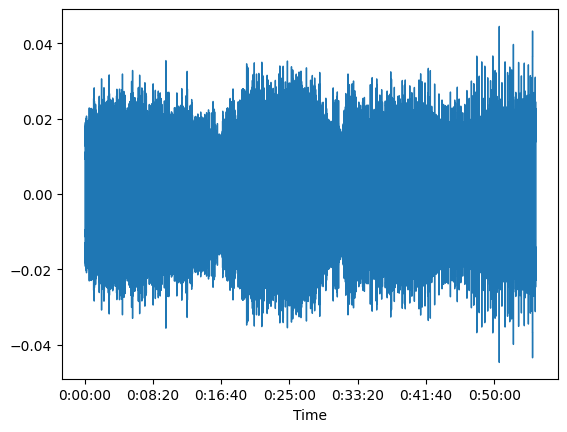

In [6]:
librosa.display.waveshow(signal, sr=sr)

22050
(500, 17, 216)


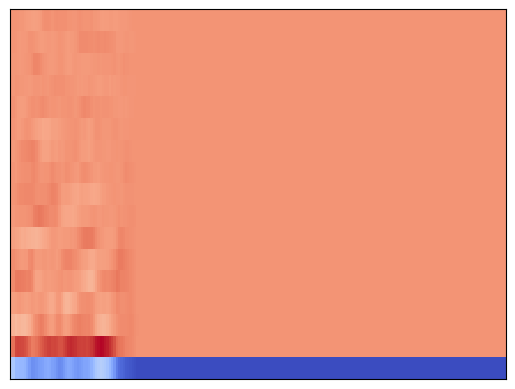

In [7]:
# display MFCC tmp data with librosa
import librosa.display
import matplotlib.pyplot as plt
print(sr)
print(tmp.shape)
librosa.display.specshow(tmp[400, :, :])

In [8]:
# labels
import pandas as pd
df = pd.read_pickle(DATA_ADDRESS+"preprocessed/df_5s.pkl")
df[df['category']=='train']

['5154' '5583' '5678' '3835' '5319' '0248' '1121' '0254' '1970' '0479'
 '6319' '0459' '7688' '4744' '0288']


/var/folders/gx/htb5vl916_j820n434lbd_2dzp39cq/T/ipykernel_14307/955314621.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['label'] = df_sub['speaker'].map(speaker_to_id)


,origin_folder,speaker,distractor,room,category,filename,label
494,distant-16k/speech/train/rm2/babb/sp7688,7688,babb,rm2,train,5seconds-16k/speech/train/rm2/babb/sp7688/Lab4...,12
495,distant-16k/speech/train/rm2/babb/sp7688,7688,babb,rm2,train,5seconds-16k/speech/train/rm2/babb/sp7688/Lab4...,12
496,distant-16k/speech/train/rm2/babb/sp7688,7688,babb,rm2,train,5seconds-16k/speech/train/rm2/babb/sp7688/Lab4...,12
497,distant-16k/speech/train/rm2/babb/sp7688,7688,babb,rm2,train,5seconds-16k/speech/train/rm2/babb/sp7688/Lab4...,12
498,distant-16k/speech/train/rm2/babb/sp7688,7688,babb,rm2,train,5seconds-16k/speech/train/rm2/babb/sp7688/Lab4...,12
...,...,...,...,...,...,...,...
73869,distant-16k/speech/train/rm1/tele/sp0479,0479,tele,rm1,train,5seconds-16k/speech/train/rm1/tele/sp0479/Lab4...,9
73870,distant-16k/speech/train/rm1/tele/sp0479,0479,tele,rm1,train,5seconds-16k/speech/train/rm1/tele/sp0479/Lab4...,9
73871,distant-16k/speech/train/rm1/tele/sp0479,0479,tele,rm1,train,5seconds-16k/speech/train/rm1/tele/sp0479/Lab4...,9
73872,distant-16k/speech/train/rm1/tele/sp0479,0479,tele,rm1,train,5seconds-16k/speech/train/rm1/tele/sp0479/Lab4...,9


In [10]:
# Random seeds
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
random_seed = 1
learning_rate = 0.05
num_epochs = 10
batch_size = 32#640

# Architecture
num_classes = 200

In [12]:
X = load_train(TRAIN_DIR, os.listdir(TRAIN_DIR))
X.shape

In [13]:
y = np.array(df[df['category']=='train']['speaker']).astype('int')
y = y[:X.shape[0]]

100%|██████████| 10/10 [00:00<00:00, 82.32it/s]


(5000, 17, 216)

In [20]:
# load model with torch
import torch
tmp = torch.load("results/basecnn_15/model.pt")

In [26]:
from data_prepare import *
data = DataPrep("data/preprocessed/train","data/preprocessed/df_index_train.pkl", 15)
data.load()
data.get_data_info()
X, y, labels = data.get_data(labels=True)

100it [00:00, 135.66it/s]


X shape: (3840, 17, 216)
y shape: (3840,)
labels shape: (3840,)
Number of unique speakers: 15
Number of unique classes: 15
Unique classes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.]


In [28]:
labels

array(['3521', '3521', '3521', ..., '5968', '5968', '5968'], dtype=object)

In [29]:
from util import DATA_ADDRESS

TRAIN_DIR = Path(DATA_ADDRESS) / "preprocessed/train"
INDEX_PATH = Path(DATA_ADDRESS) / "preprocessed/df_index_train.pkl"

data = DataPrep(TRAIN_DIR, INDEX_PATH, 15)
data.load()


100it [00:00, 141.88it/s]


In [30]:
data.df_index_reference

,file_index,pkl_filename,pkl_filename_index,n_samples_per_speaker,speaker,speaker_full_array_index,speaker_class,speaker15,speaker15_class
446,446,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,446,27,1,10.0
447,447,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,447,27,1,10.0
448,448,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,448,27,1,10.0
449,449,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,449,27,1,10.0
450,450,mfcc_len5_fft2048_mels128_mfcc17_0-499.pkl,0,256,3521,450,27,1,10.0
...,...,...,...,...,...,...,...,...,...
49231,231,mfcc_len5_fft2048_mels128_mfcc17_49000-49499.pkl,49000,256,5968,49231,78,1,3.0
49232,232,mfcc_len5_fft2048_mels128_mfcc17_49000-49499.pkl,49000,256,5968,49232,78,1,3.0
49233,233,mfcc_len5_fft2048_mels128_mfcc17_49000-49499.pkl,49000,256,5968,49233,78,1,3.0
49234,234,mfcc_len5_fft2048_mels128_mfcc17_49000-49499.pkl,49000,256,5968,49234,78,1,3.0


In [1]:
from util import *
import torch
preds, truths = load_pickle("results/basecnn15/predictions.pkl")

In [2]:
model_set = torch.load("results/basecnn15/model.pt")
model = model_set["model"]

In [4]:
pred_train, prob_train, true_train = predict(model, model_set["train_loader"], get_cuda_device())
pred_val, prob_val, true_val = predict(model, model_set["val_loader"], get_cuda_device())

120it [00:00, 161.17it/s]
18it [00:00, 165.38it/s]


In [7]:
# concatenate the predictions as they are 18 arrays
pred_train = np.concatenate(pred_train, axis=0)
true_train = np.concatenate(true_train, axis=0)

prob_train = np.concatenate(prob_train, axis=0)
prob_val = np.concatenate(prob_val, axis=0)

pred_val = np.concatenate(pred_val, axis=0)
true_val = np.concatenate(true_val, axis=0)


In [15]:
# compute AUC score for predicted probabilities


1.0

In [23]:
# classification metrics:  accuracy, precision, recall, F1
from sklearn.metrics import roc_auc_score
auc_train = roc_auc_score(true_train, prob_train, average='macro', multi_class='ovr')
auc_val = roc_auc_score(true_val, prob_val, average='macro', multi_class='ovr')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score
# create a table for training and validation metrics
metrics = {
    "Accuracy": [accuracy_score(true_train, pred_train), accuracy_score(true_val, pred_val)],
    "Precision": [precision_score(true_train, pred_train, average='macro'), precision_score(true_val, pred_val, average='macro')],
    "Recall": [recall_score(true_train, pred_train, average='macro'), recall_score(true_val, pred_val, average='macro')],
    "F1": [f1_score(true_train, pred_train, average='macro'), f1_score(true_val, pred_val, average='macro')],
    "AUC": [auc_train, auc_val],
    "Kappa": [cohen_kappa_score(true_train, pred_train), cohen_kappa_score(true_val, pred_val)]
}

In [24]:
# write them as data frame to save to CSV
import pandas as pd
metrics_df = pd.DataFrame(metrics, index=["Train", "Validation"])
metrics_df

,Accuracy,Precision,Recall,F1,AUC,Kappa
Train,0.99974,0.999741,0.99974,0.99974,1.0,0.999721
Validation,1.00000,1.000000,1.00000,1.00000,1.0,1.000000


In [10]:
predict(model, model_set["train_loader"], device)

0it [00:00, ?it/s]


AttributeError: 'collections.OrderedDict' object has no attribute 'forward'

In [ ]:
model_set["val_loader"]

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class VoiceDataset(Dataset):
    def __init__(self, X, y):
        assert len(X) == len(y), "The lengths of X and y must match"
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convert the numpy arrays to PyTorch tensors
        sample = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return sample, label

# Assuming X and y are your data and labels loaded in memory
# X is our features array with shape (N, 17, 216), and y is a labels array

# Initialize your dataset
dataset = VoiceDataset(X, y)

# Create a DataLoader
batch_size = 32  # Define your batch size
shuffle = True  # Shuffle the data for training
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
#
# # Example of iterating through the DataLoader
# for batch_idx, (data, labels) in enumerate(data_loader):
#     print(f"Batch {batch_idx}: Data shape {data.shape}, Labels shape {labels.shape}")
#     # Here you can pass your data and labels to your model for training or inference


In [16]:
from models_cnn import BaseNet

# Initialize the model
model = BaseNet(num_classes=len(np.unique(y)))

In [27]:
dataset

,train_idx,speaker,label
288,288,5789,0
289,289,5789,0
290,290,5789,0
291,291,5789,0
292,292,5789,0
...,...,...,...
4709,4709,8677,2
4710,4710,8677,2
4711,4711,8677,2
4712,4712,8677,2


1. Random sample of the index data (train) for 5 second samples of 15 speakers (64 samples each)
2. Process through the preprocessing pipeline (transformation of data loader) on the fly by sample level
3. Train a simple base CNN model architecture

Batch 0: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 1: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 2: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 3: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 4: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 5: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 6: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 7: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 8: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 9: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 10: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 11: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([32])
Batch 12: Data shape torch.Size([32, 17, 216]), Labels shape torch.Size([3